In [1]:
import numpy as np

tms = np.loadtxt('m.txt', delimiter='\t') # return (N, 2) array
times = tms[:, 0]                         # return only 1st col
masses = tms[:, 1]                        # return only 2nd col

trs = np.loadtxt('r.txt', delimiter='\t')
Rsuns = trs[:, 1]                         # data in Rsun units
radii = np.zeros(Rsuns.size)
for i, r in enumerate(Rsuns):
    radii[i] = r * 0.00465047             # convert Rsun to AU

In [2]:
print("\n TIME\n----------")
print("Type:", type(times))
print("Shape:", times.shape)
print(times)
print("\n MASS\n----------")
print("Type:", type(masses))
print("Shape:", masses.shape)
print(masses)
print("\n RADIUS\n----------")
print("Type:", type(radii))
print("Shape:", radii.shape)
print(radii)


 TIME
----------
Type: <class 'numpy.ndarray'>
Shape: (4324,)
[1.23895044e+10 1.23895167e+10 1.23895290e+10 ... 1.23935392e+10
 1.23935586e+10 1.23935819e+10]

 MASS
----------
Type: <class 'numpy.ndarray'>
Shape: (4324,)
[0.86453882 0.86421144 0.86388387 ... 0.57513924 0.57513467 0.57512888]

 RADIUS
----------
Type: <class 'numpy.ndarray'>
Shape: (4324,)
[0.38338383 0.38407729 0.38477933 ... 0.04573165 0.04682025 0.04941497]


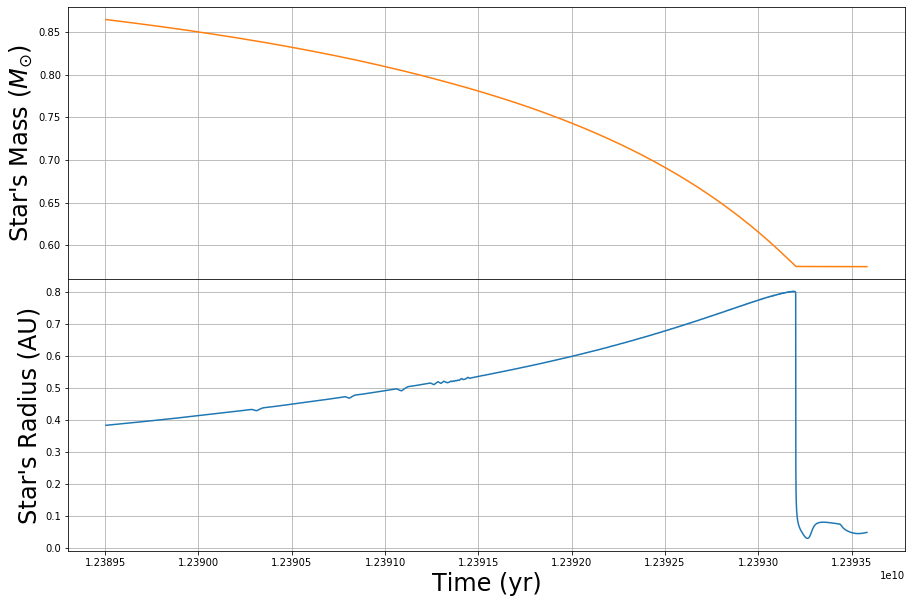

In [3]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))
fig.subplots_adjust(hspace=0)
ax1.set_ylabel("Star's Mass ($M_{\odot}$)", fontsize=24)
ax1.plot(times,masses, color="tab:orange")
ax1.grid()
ax2.set_xlabel("Time (yr)", fontsize=24)
ax2.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax2.set_ylabel("Star's Radius (AU)", fontsize=24)
ax2.plot(times,radii)
ax2.grid()

In [4]:
import rebound
import reboundx

M0 = masses[0]                       # initial mass of star
R0 = radii[0]                        # initial radius of star

def makesim():
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2               # use units of AU, yrs and solar masses
    sim.add(m=M0, r=R0, hash="Star")
    sim.add(a=1., hash="Earth")
    sim.integrator = "whfast"
    sim.dt = 0.1*sim.particles[1].P
    sim.move_to_com()
    return sim

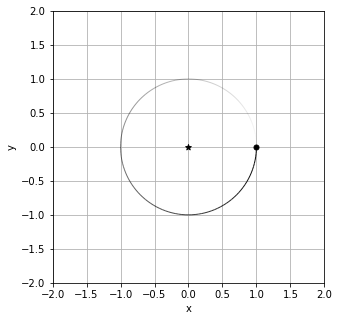

In [5]:
%matplotlib inline
sim = makesim()
ps = sim.particles
fig, ax = rebound.OrbitPlot(sim)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.grid()

In [6]:
rebx = reboundx.Extras(sim)

starmass = reboundx.Interpolator(rebx, times, masses, "spline")
starradius = reboundx.Interpolator(rebx, times, radii, "spline")

In [7]:
T0 = times[0]
t = 0
print("mass =", starmass.interpolate(rebx, t=T0+t))
print("radius =", starradius.interpolate(rebx, t=T0+t))

mass = nan
radius = nan


CPU times: user 1min 31s, sys: 25.5 s, total: 1min 56s
Wall time: 1min 56s


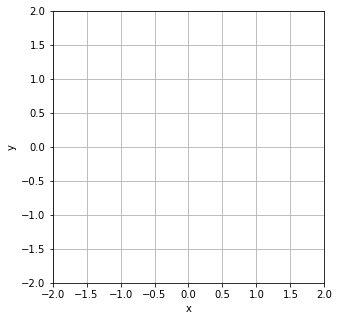

In [8]:
%%time
Nout = 1000
mass = np.zeros(Nout)
radius = np.zeros(Nout)
a = np.zeros(Nout)
ts = np.linspace(0., 4.e6, Nout)
T0 = times[0]                    # Sun's age at simulation start

for i, time in enumerate(ts):
    sim.integrate(time)
    ps[0].m = starmass.interpolate(rebx, t=T0+sim.t)
    ps[0].r = starradius.interpolate(rebx, t=T0+sim.t)
    sim.move_to_com() # lost mass had momentum, so need to move back to COM frame
    mass[i] = sim.particles[0].m
    radius[i] = sim.particles[0].r
    a[i] = sim.particles[1].a
    
fig, ax = rebound.OrbitPlot(sim)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.grid()

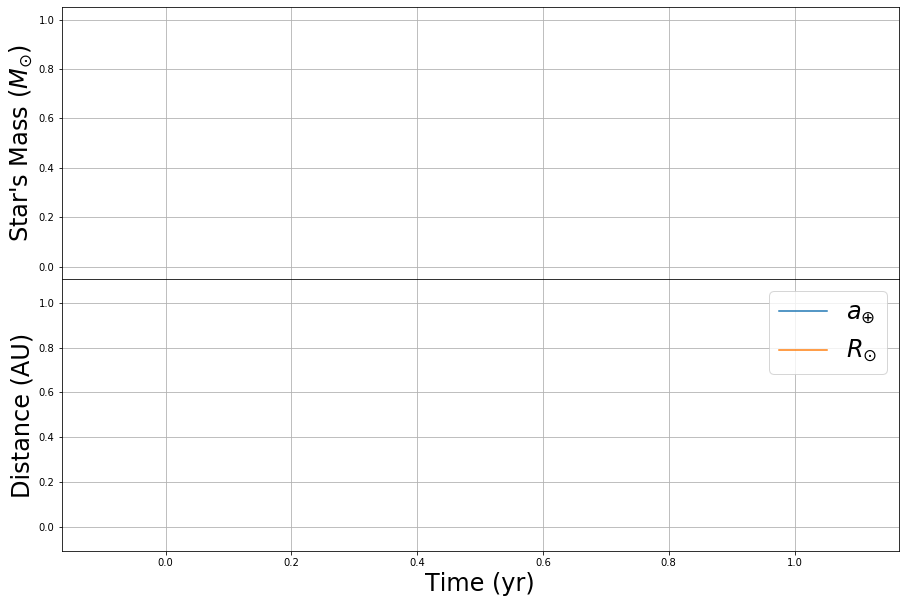

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))
fig.subplots_adjust(hspace=0)
ax1.set_ylabel("Star's Mass ($M_{\odot}$)", fontsize=24)
ax1.plot(ts,mass, color="tab:orange")
ax1.grid()
ax2.set_xlabel("Time (yr)", fontsize=24)
ax2.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax2.set_ylabel("Distance (AU)", fontsize=24)
ax2.plot(ts,a, label="$a_{\oplus}$")
ax2.plot(ts,radius, label='$R_{\odot}$')
ax2.legend(fontsize=24, loc="best")
ax2.grid()